<a href="https://colab.research.google.com/github/ChristopherJS0/Road-Crack-Detection/blob/master/Training_on_Road_Crack_Dataset_with_Yolov9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May 22 23:28:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 325 (delta 159), reused 156 (delta 156), pack-reused 107
Receiving objects: 100% (325/325), 2.23 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.3 MB/s eta 0:00:00


**NOTE:** Installing roboflow onto local pc so that we can access datasets we'll use to train the model.

In [4]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00


## Imports

In [5]:
import roboflow

from IPython.display import Image

## Download model weights

**NOTE:** In the YOLOv9 paper, versions yolov9-s and yolov9-m are also mentioned, but the weights for these models are not yet available in the YOLOv9 repository.

In [6]:
!mkdir -p {HOME}/weights

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls -la {HOME}/weights

total 402444
drwxr-xr-x 2 root root      4096 May 22 23:30 .
drwxr-xr-x 1 root root      4096 May 22 23:30 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.
Thanks to the dataset made by:

Sateesh. (2024). Crack Dataset [Open Source Dataset]. Roboflow Universe. https://universe.roboflow.com/sateesh/crack-ekaue

In [10]:
%cd {HOME}/yolov9

from roboflow import Roboflow
rf = Roboflow(api_key="3sumATBgRMc4Cei8GvLO")
project = rf.workspace("sateesh").project("crack-ekaue")
version = project.version(2)
dataset = version.download("yolov9")


/content/yolov9
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to crack-2 in yolov9:: 100%|██████████| 2244/2244 [00:00<00:00, 4468.99it/s]


In [22]:
%cd {HOME}/yolov9
!mkdir -p weights
!cp -a /content/weights/. /content/yolov9/weights/

/content/yolov9


In [11]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 8.5 MB/s eta 0:00:00


## Train Custom Model


**Note:** Epochs can be changed to a lower/higher number and so can image amount. We use train_dual here since yolov9 datasets work with train_dual instead of train.py.

In [24]:
%cd {HOME}/yolov9

!python train_dual.py \
--batch 8 --epochs 20 --img 620 --device 0 \
--data crack-2/data.yaml \
--weights weights/yolov9-c.pt \
--cfg models/detect/yolov9.yaml \
--hyp data/hyps/hyp.scratch-high.yaml

/content/yolov9
2024-05-22 23:46:08.773807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 23:46:08.773879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 23:46:08.775981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 23:46:08.787820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 23:46:10.526534: W tensorf

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [25]:
!ls {HOME}/yolov9/runs/train/exp/

events.out.tfevents.1716420884.09f4cdcee04b.2423.0  hyp.yaml  opt.yaml	weights


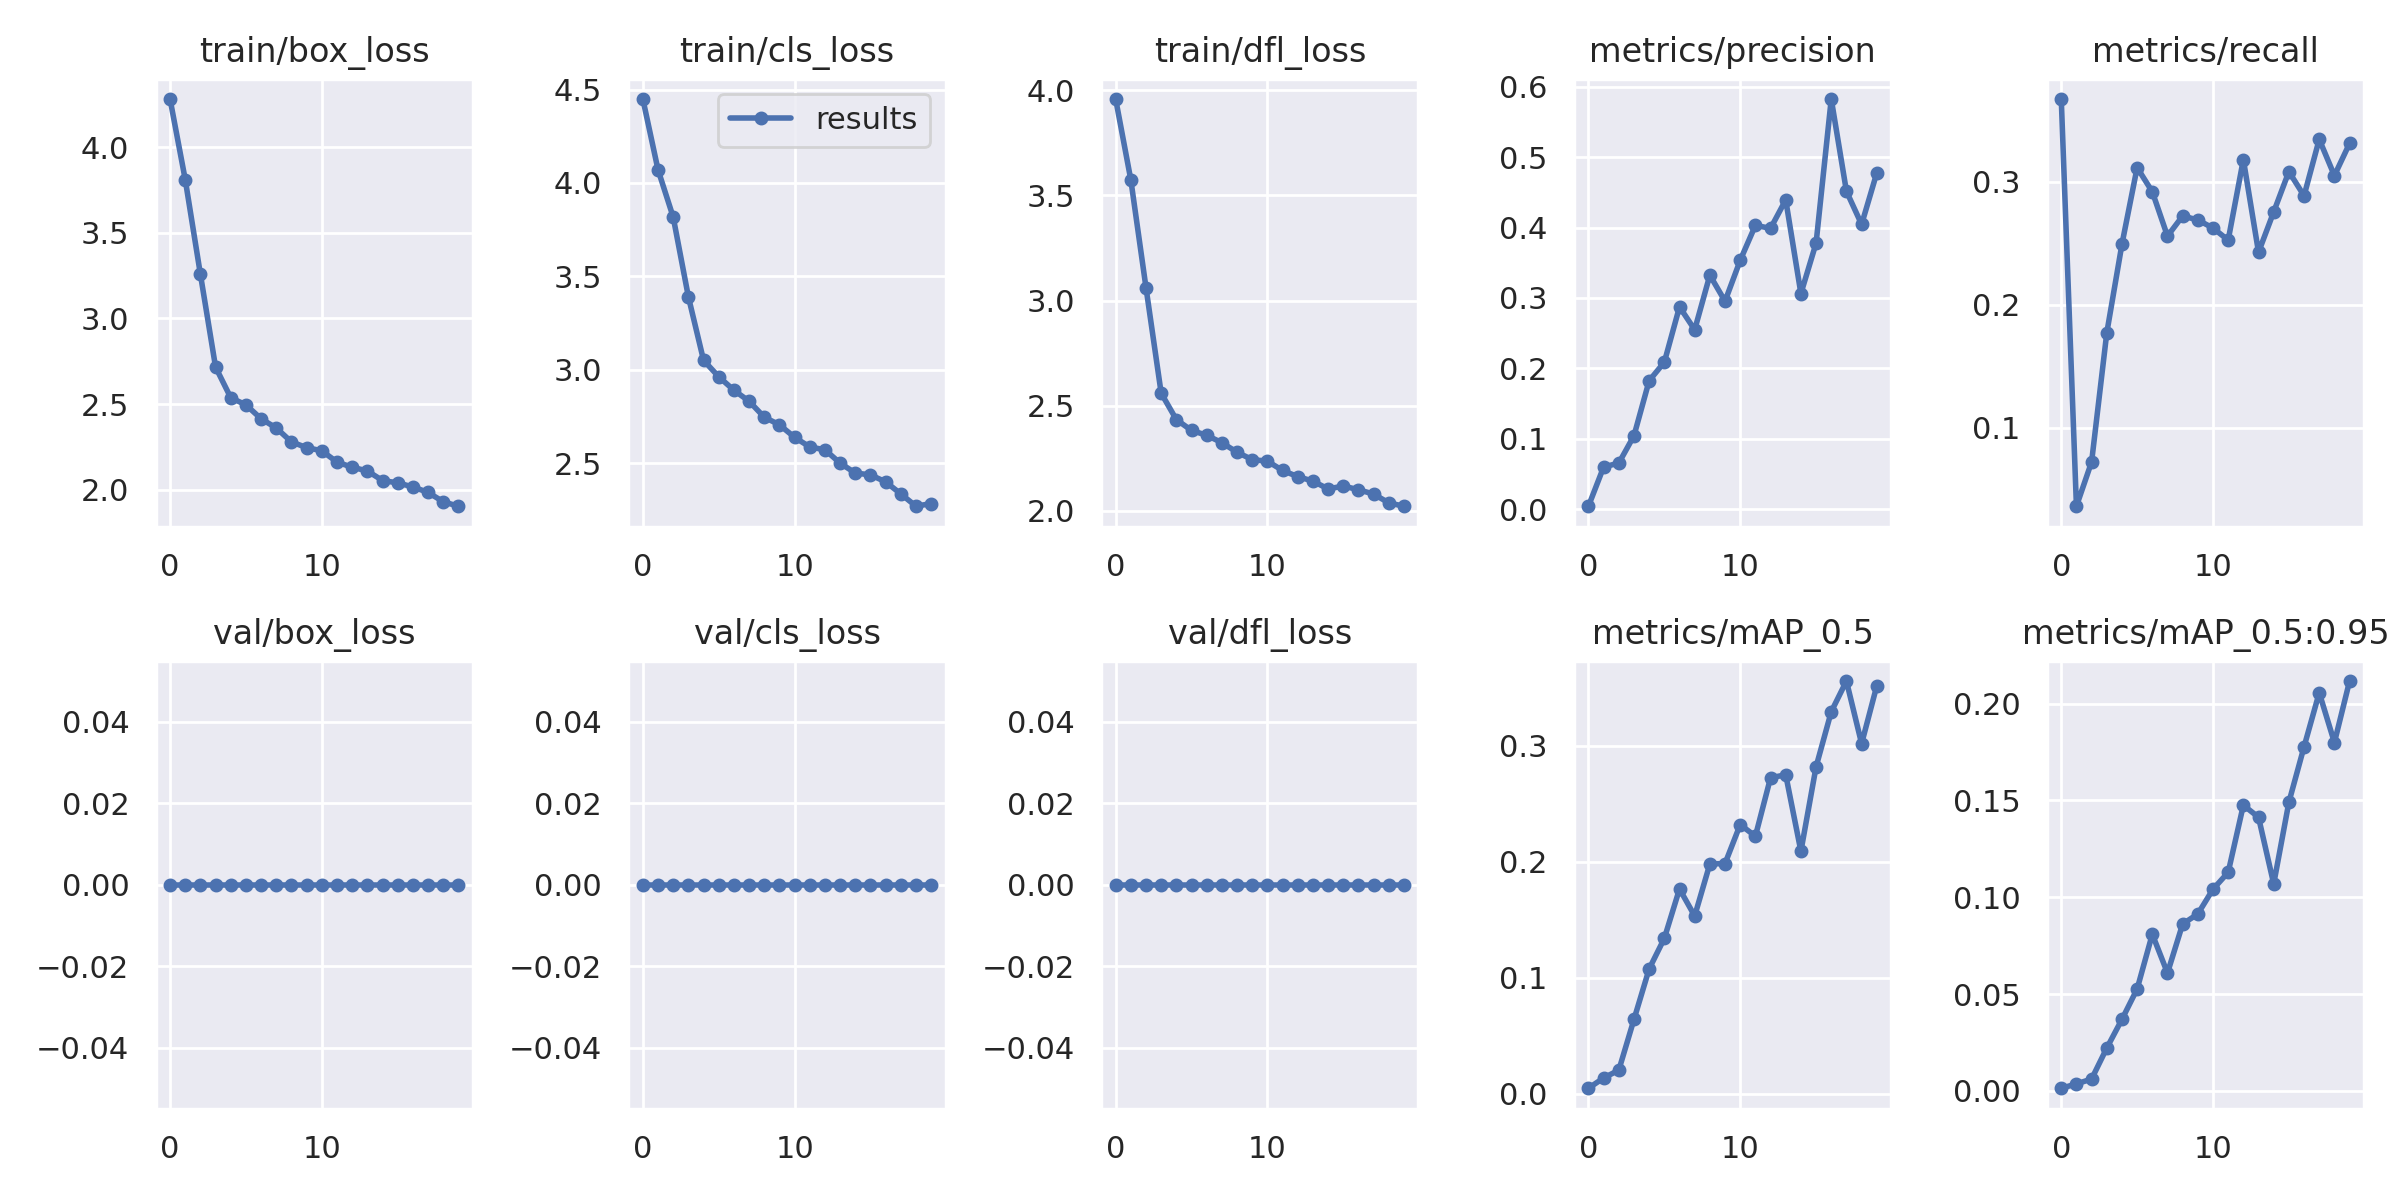

In [27]:
Image(filename=f"{HOME}/yolov9/runs/train/exp4/results.png", width=1000)

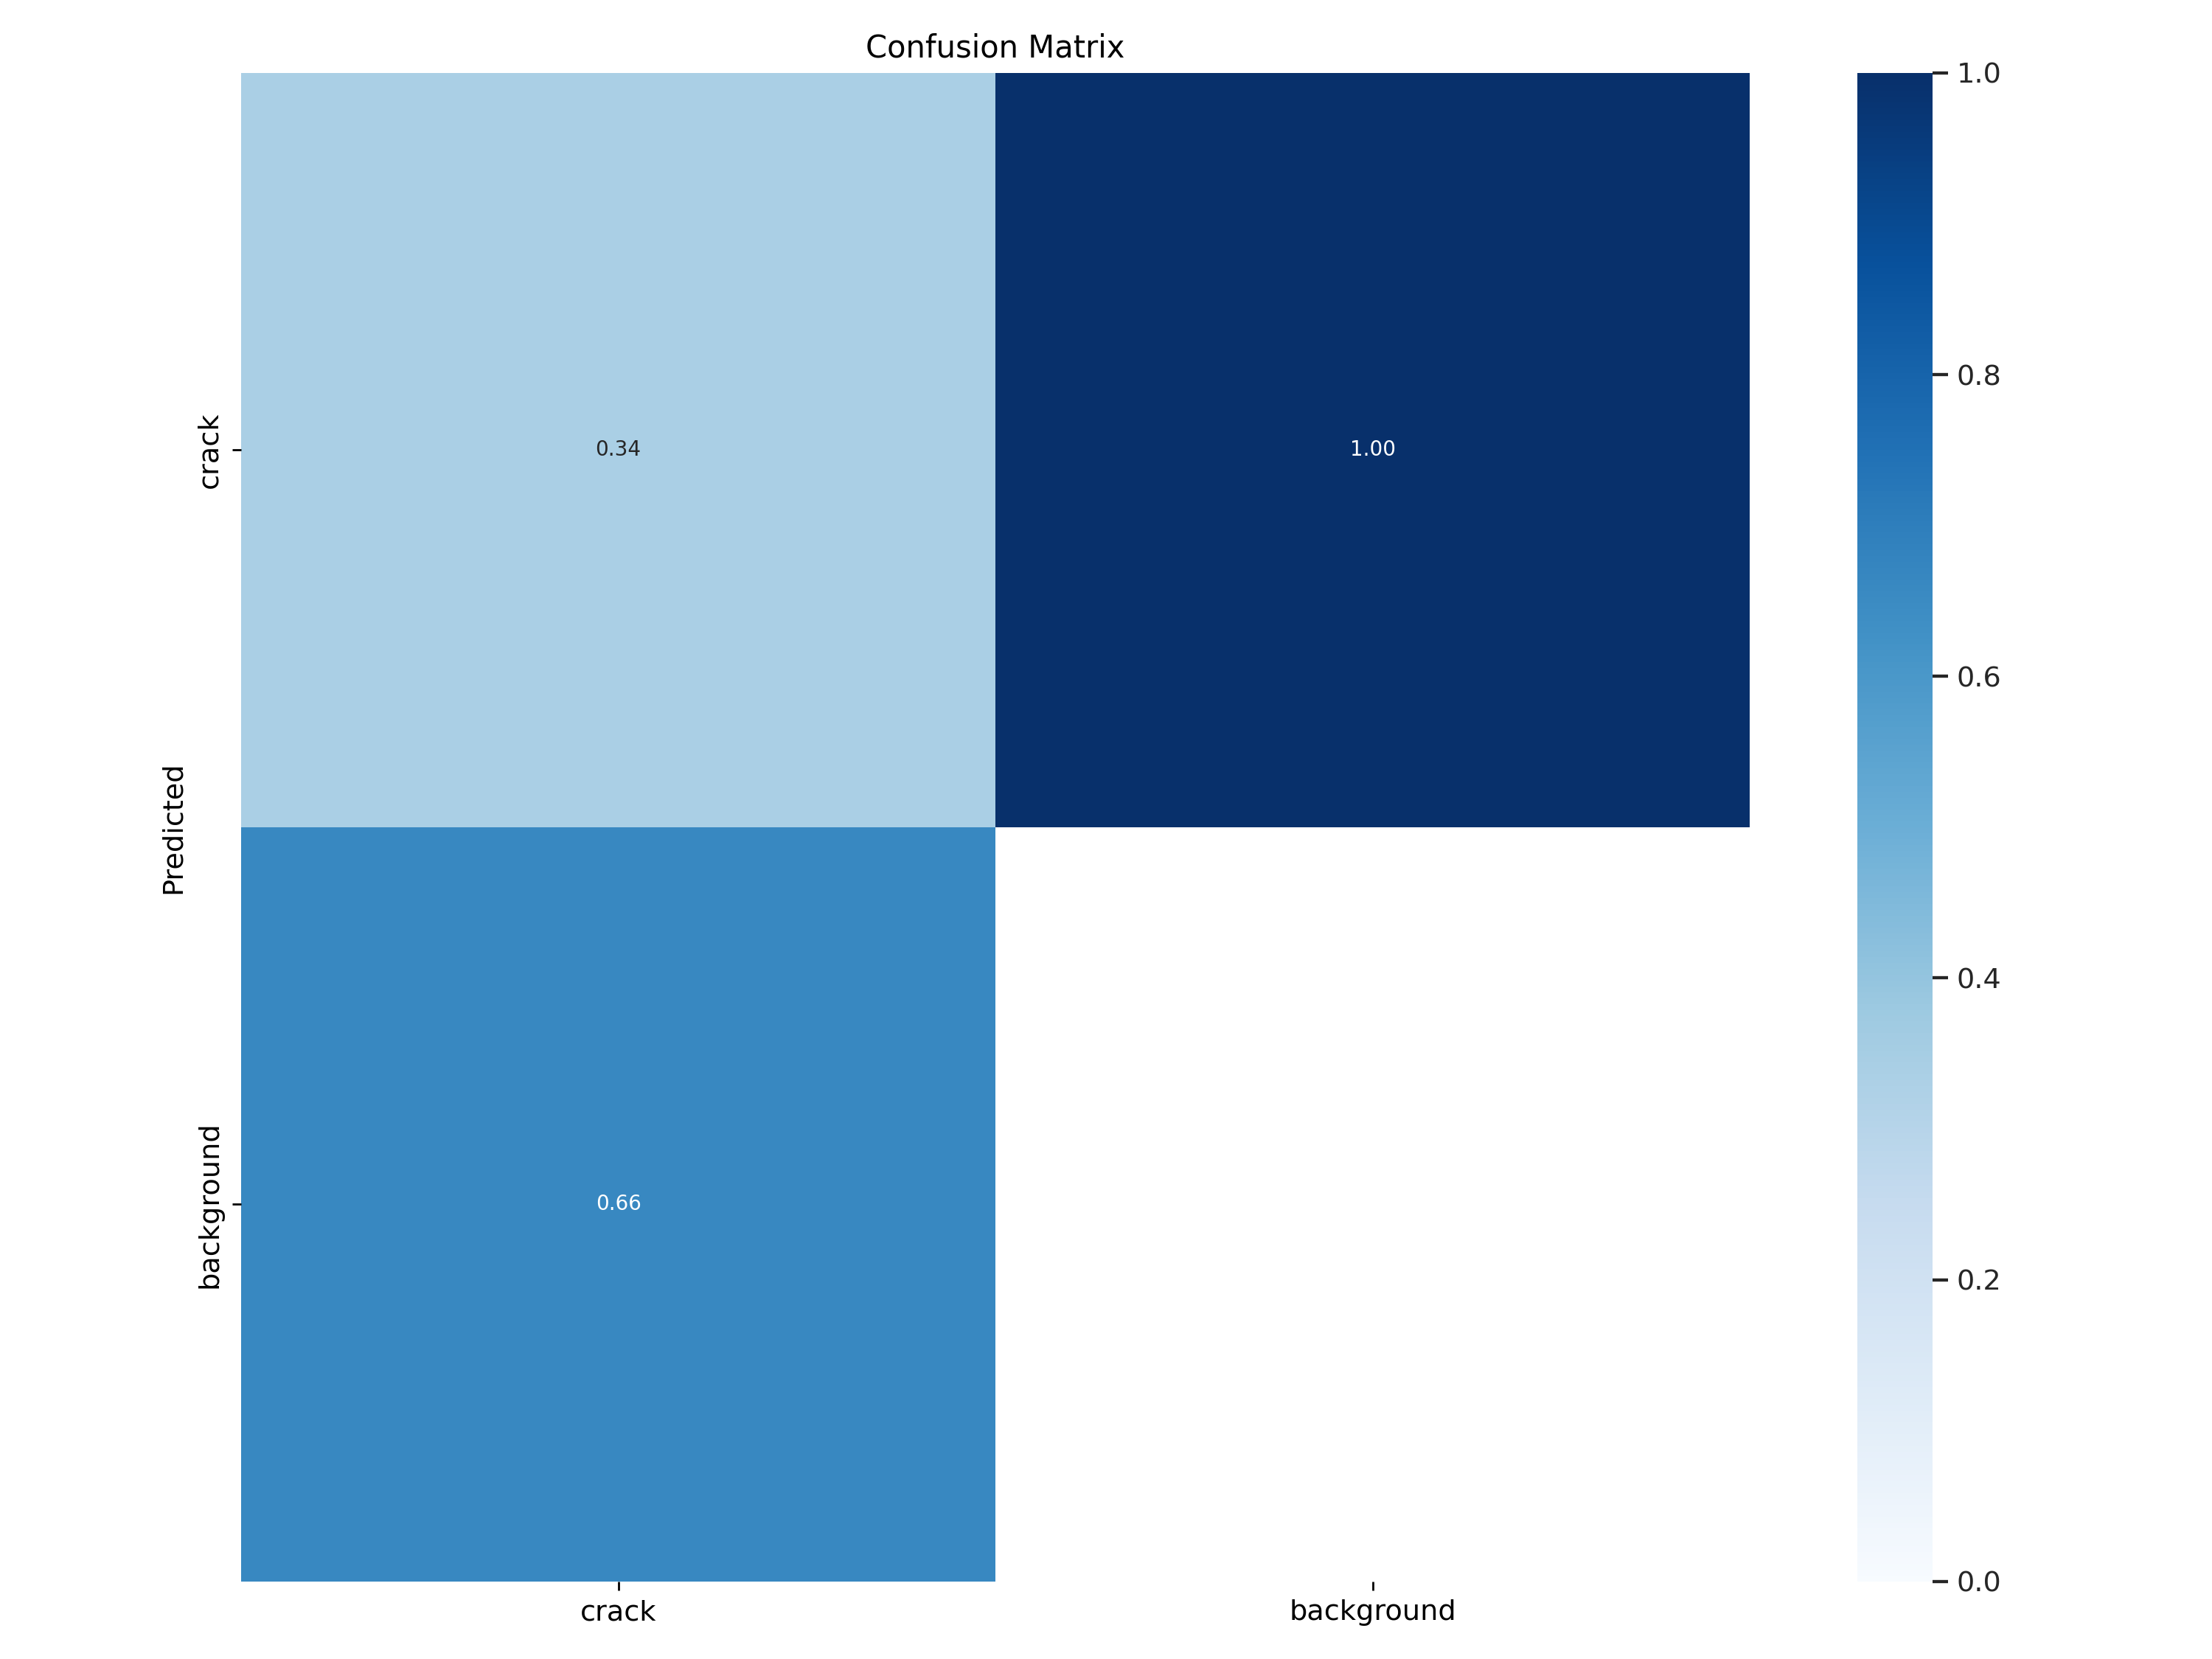

In [29]:
Image(filename=f"{HOME}/yolov9/runs/train/exp4/confusion_matrix.png", width=1000)

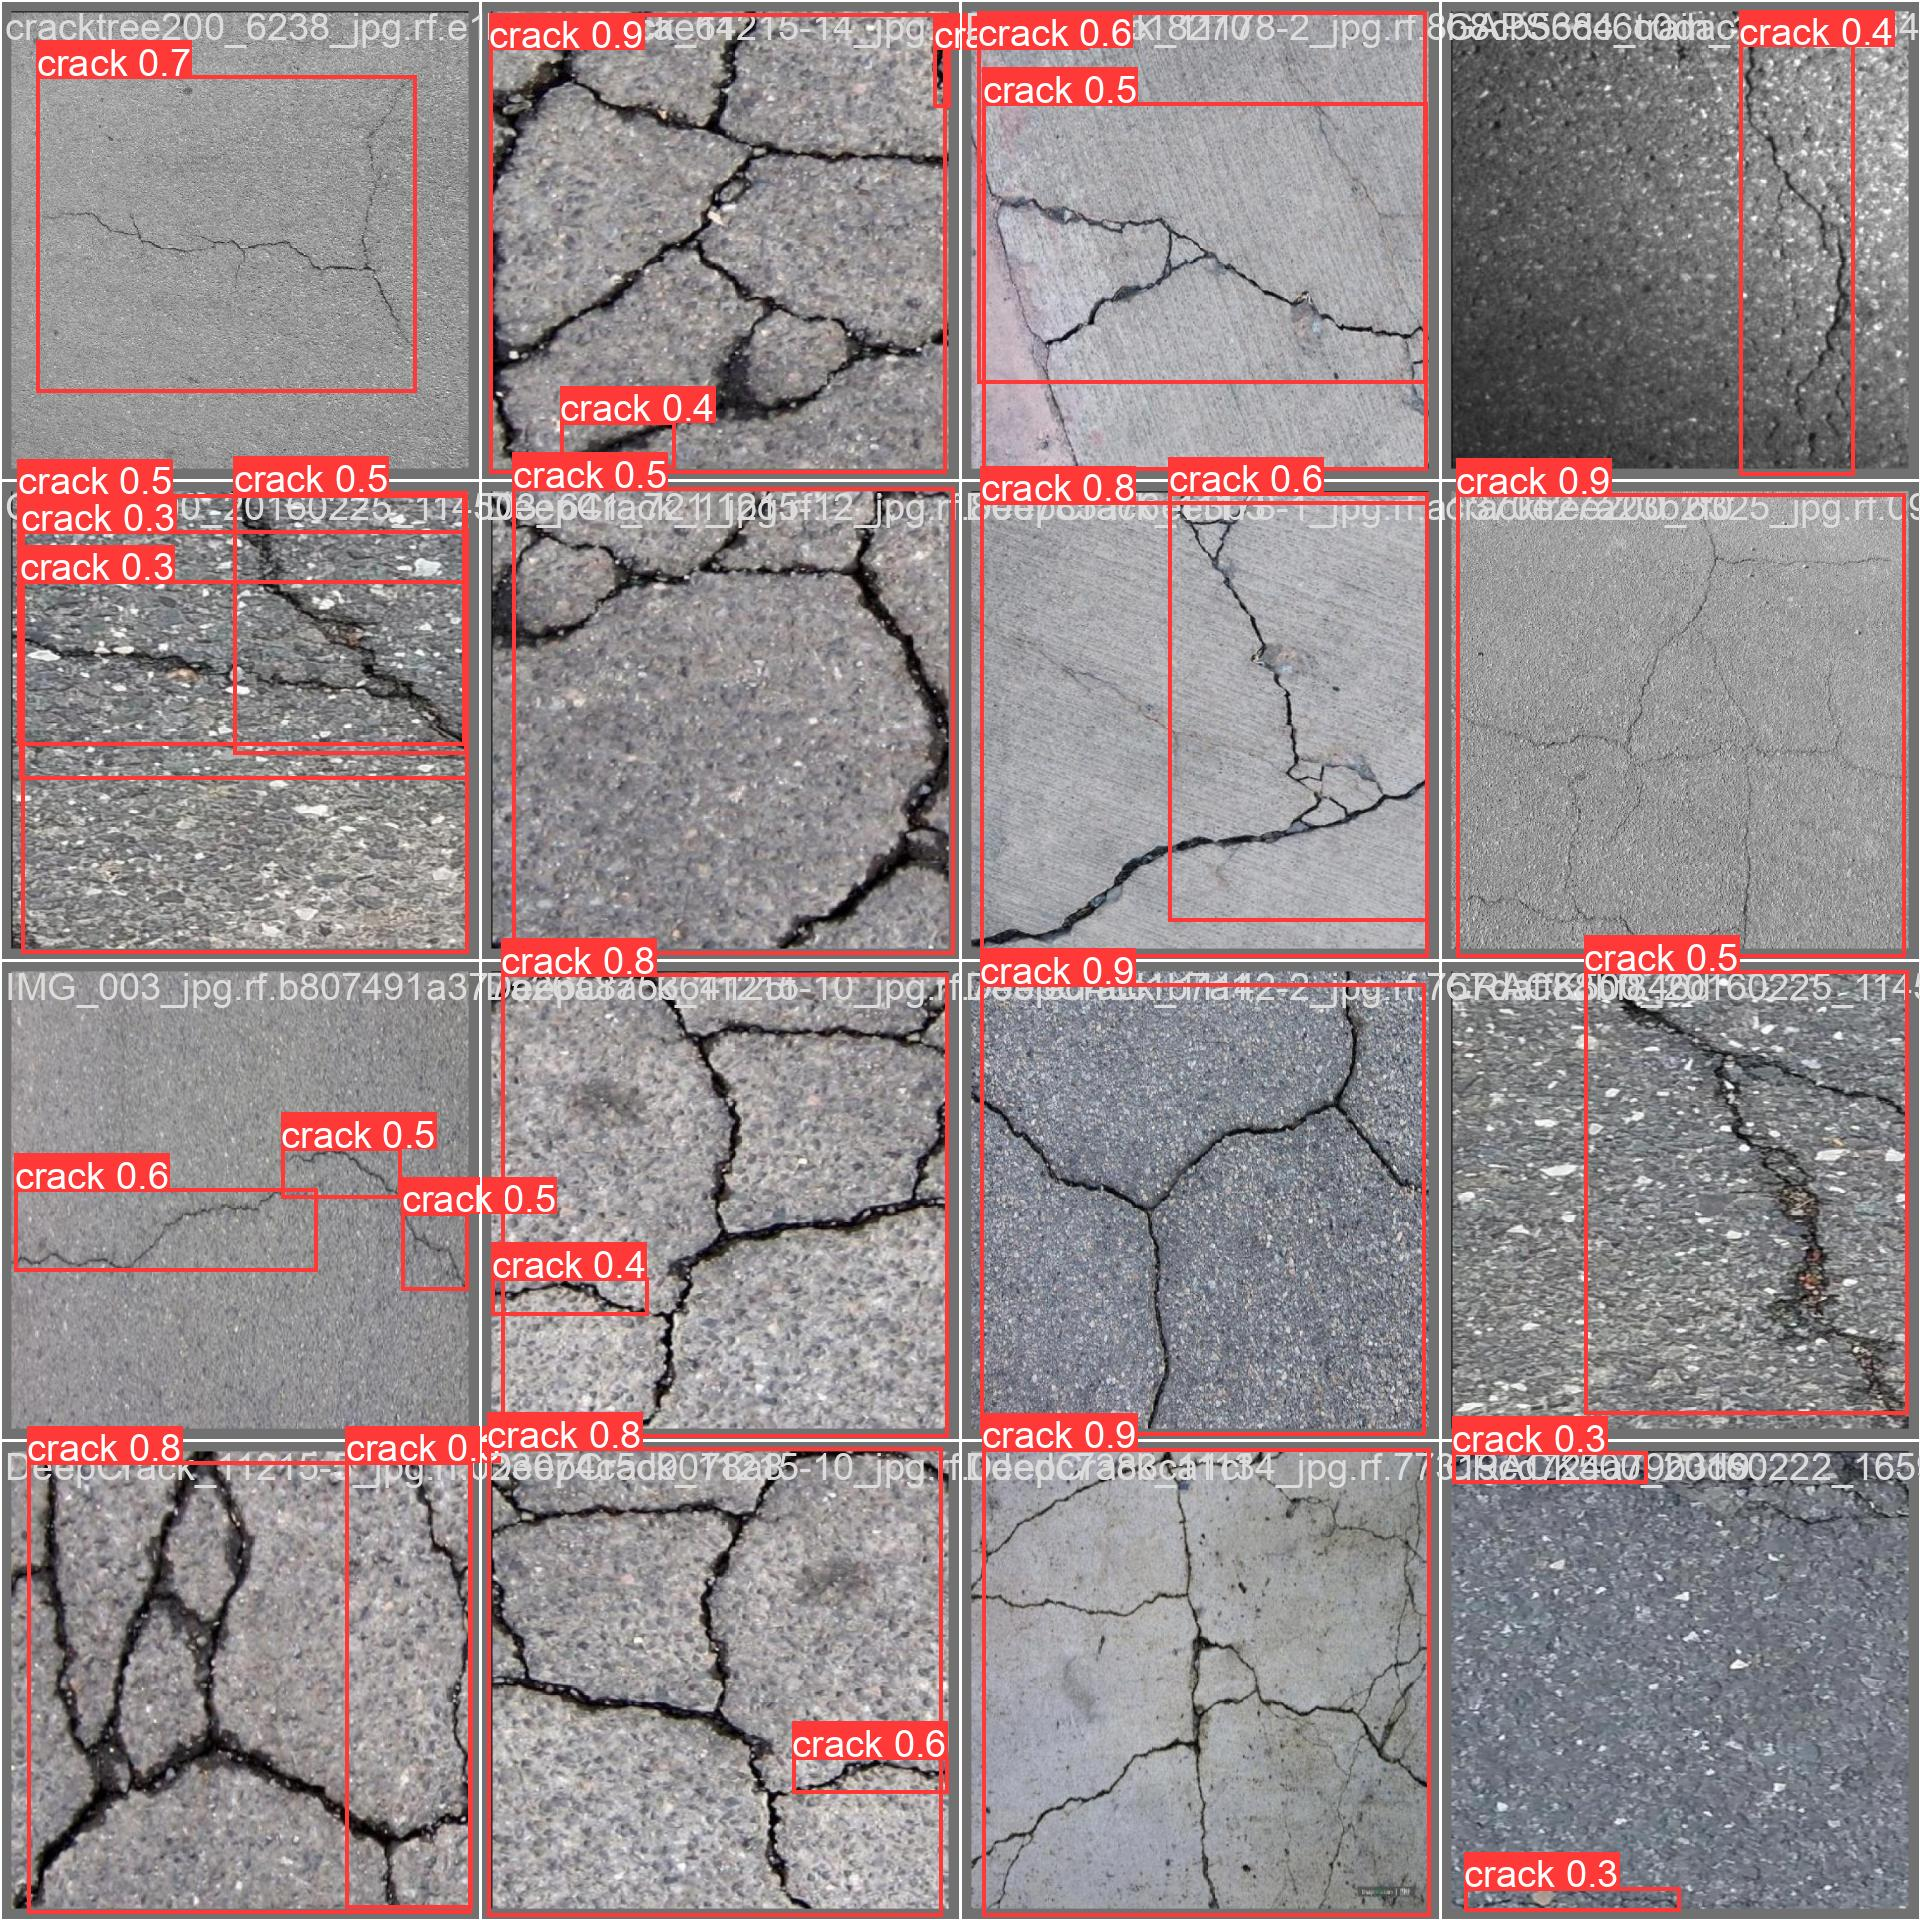

In [30]:
Image(filename=f"{HOME}/yolov9/runs/train/exp4/val_batch2_pred.jpg", width=1000)

## Validate Custom Model
Might need to be skipped over since possible bug that reads...

File "/content/yolov9/utils/general.py", line 905, in non_max_suppression
    device = prediction.device
AttributeError: 'list' object has no attribute 'device'

In [33]:
%cd {HOME}/yolov9

!python val.py \
--img 620 --batch 8 --conf 0.001 --iou 0.7 --device 0 \
--data crack-2/data.yaml \
--weights runs/train/exp4/weights/best.pt

/content/yolov9
val: data=crack-2/data.yaml, weights=['runs/train/exp4/weights/best.pt'], batch_size=8, imgsz=620, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov9 summary: 700 layers, 60756262 parameters, 0 gradients, 264.9 GFLOPs
WARNING ⚠️ --img-size 620 must be multiple of max stride 32, updating to 640
val: Scanning /content/yolov9/crack-2/valid/labels.cache... 93 images, 1 backgrounds, 0 corrupt: 100% 93/93 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/12 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/yolov9/val.py", line 389, in <module>
    main(opt)
  File "/content/y

## Inference with Custom Model

In [34]:
!python detect.py \
--img 620 --conf 0.1 --device 0 \
--weights runs/train/exp4/weights/best.pt \
--source crack-2/valid/images

detect: weights=['runs/train/exp4/weights/best.pt'], source=crack-2/valid/images, data=data/coco128.yaml, imgsz=[620, 620], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov9 summary: 700 layers, 60756262 parameters, 0 gradients, 264.9 GFLOPs
WARNING ⚠️ --img-size [620, 620] must be multiple of max stride 32, updating to [640, 640]
image 1/93 /content/yolov9/crack-2/valid/images/CFD_007_jpg.rf.edf056be81b4261124b05832ad509520.jpg: 640x640 4 cracks, 81.8ms
image 2/93 /content/yolov9/crack-2/valid/images/CFD_011_jpg.rf.4b3ae3b0c7352ec17e1df7988d79c418.jpg: 640x640 2 cracks, 74.2ms
image 3/

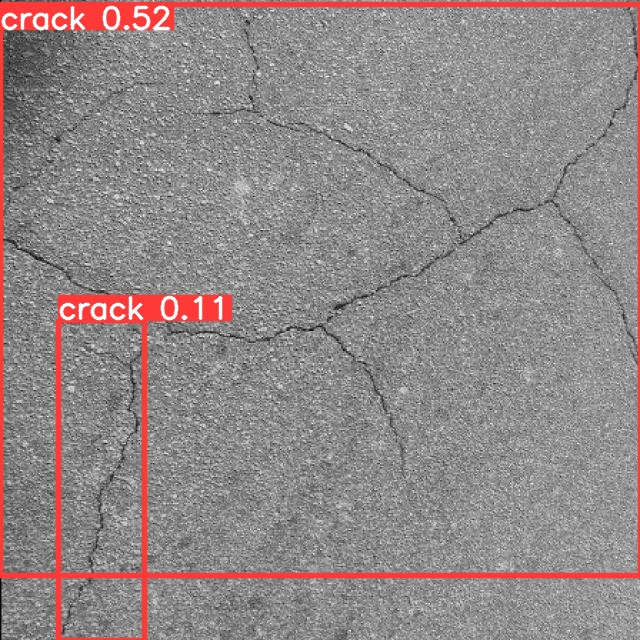

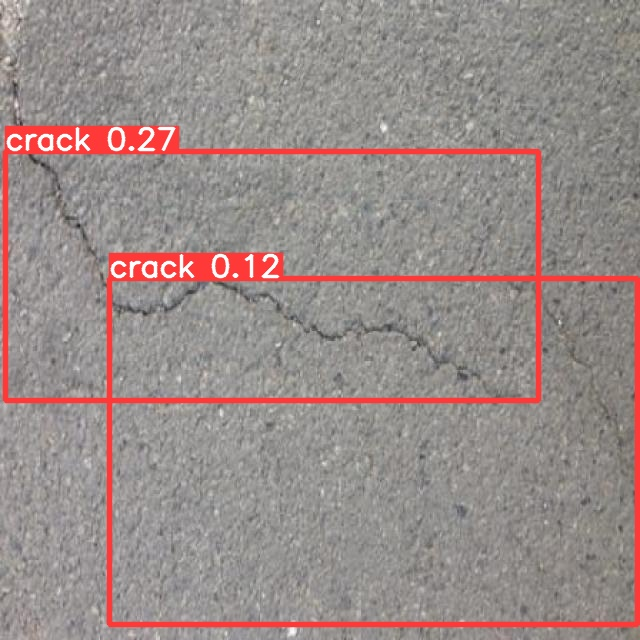

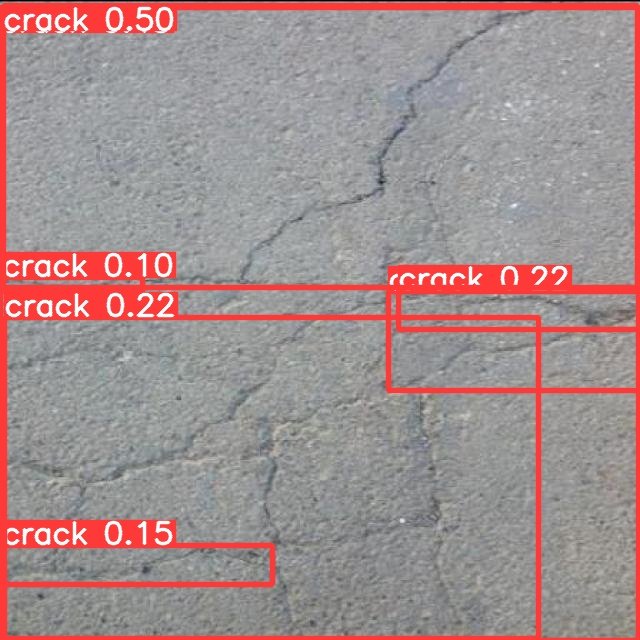

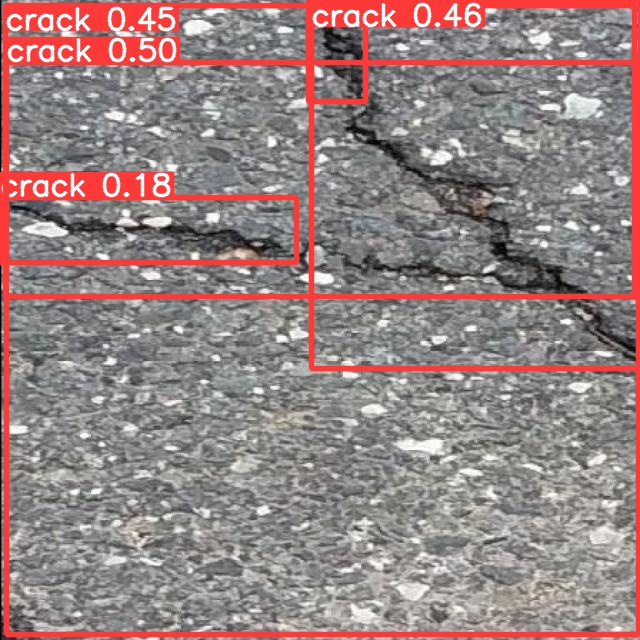

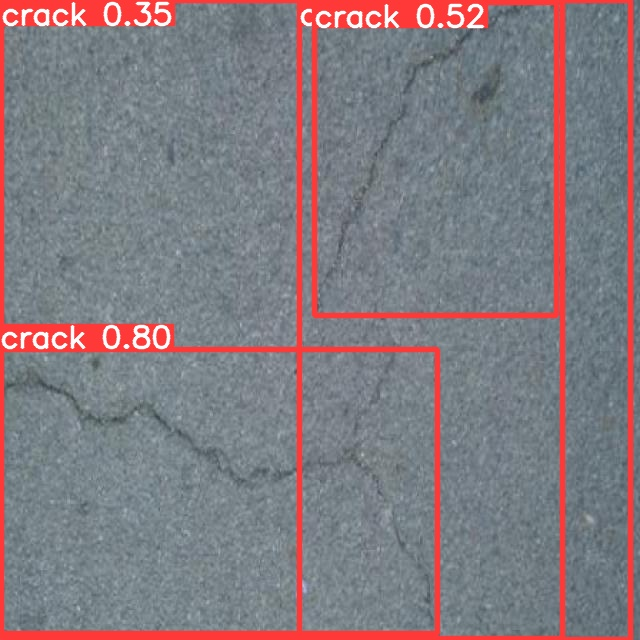

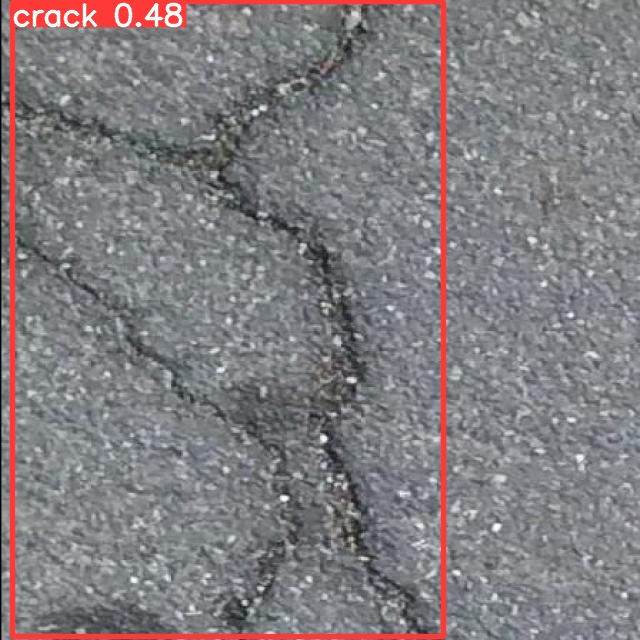

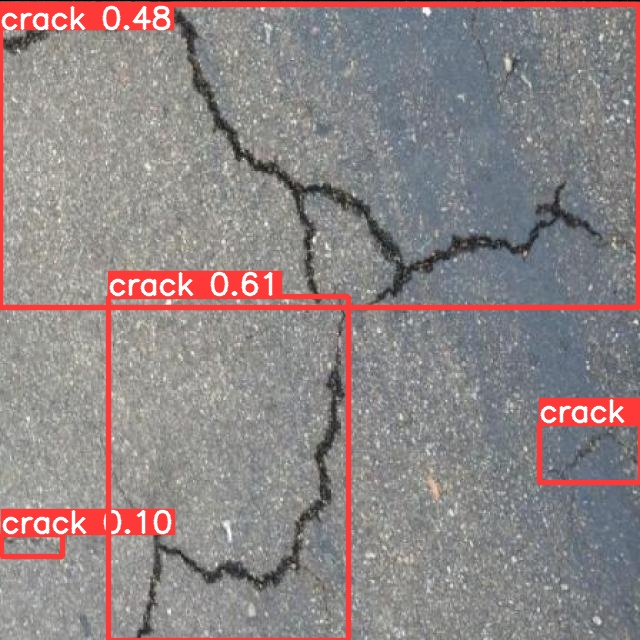

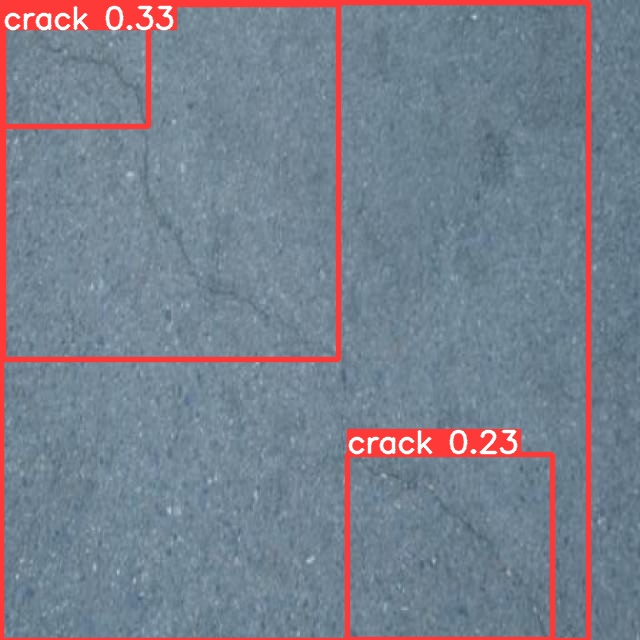

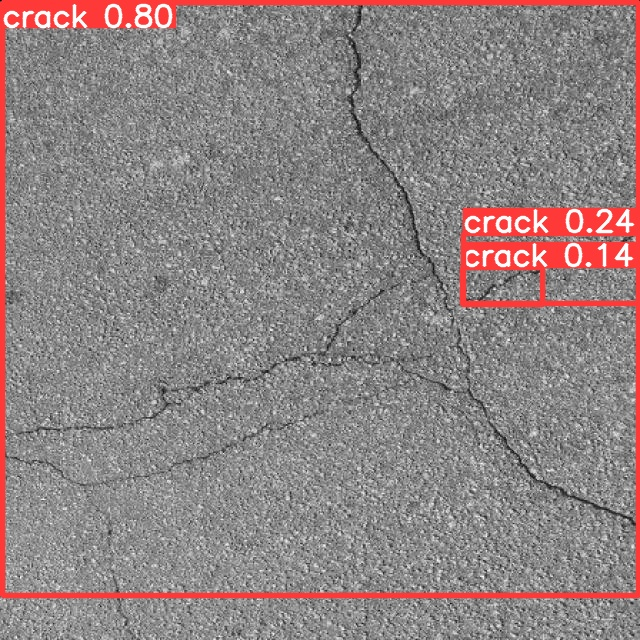

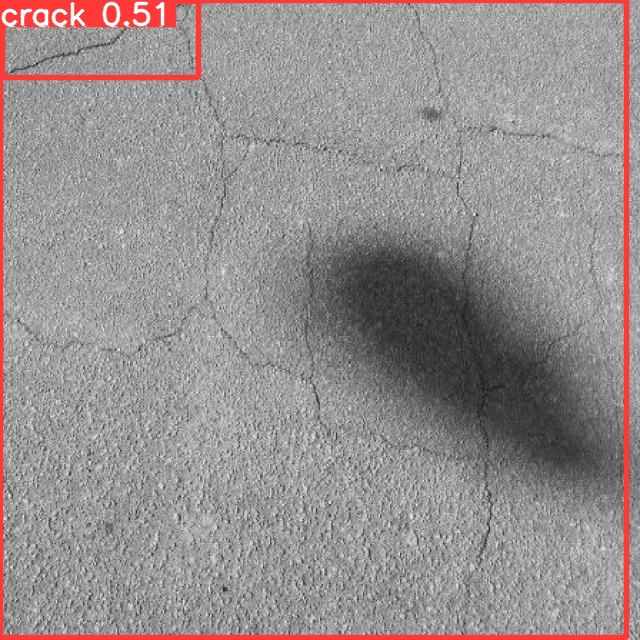

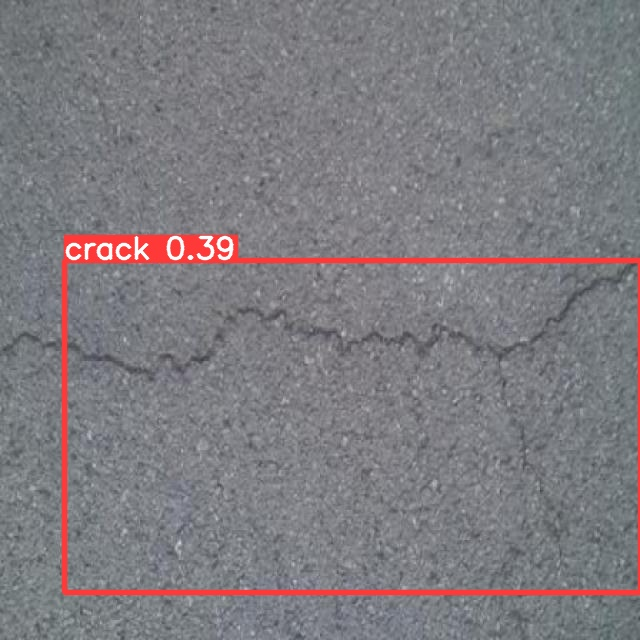

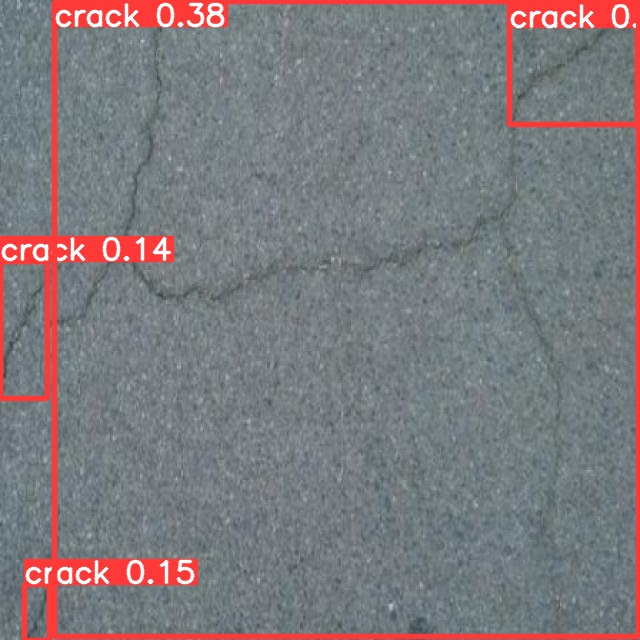

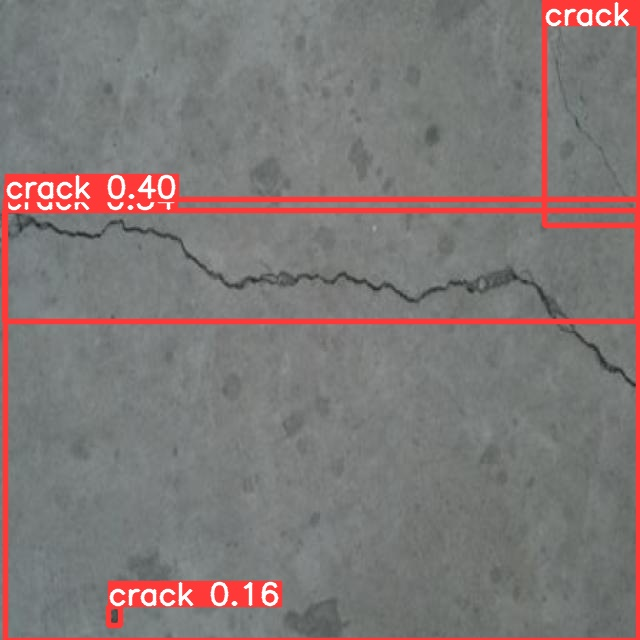

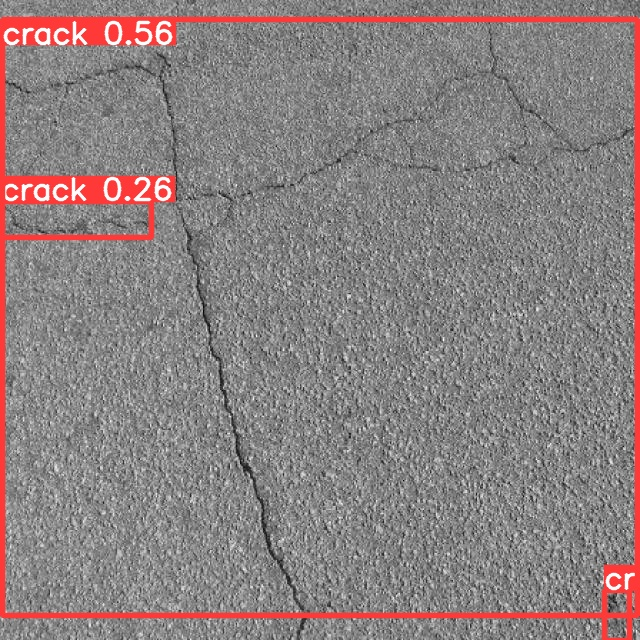

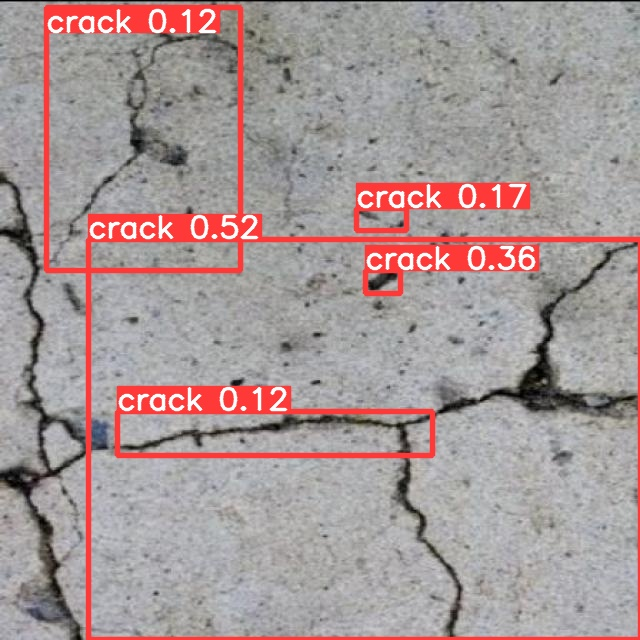

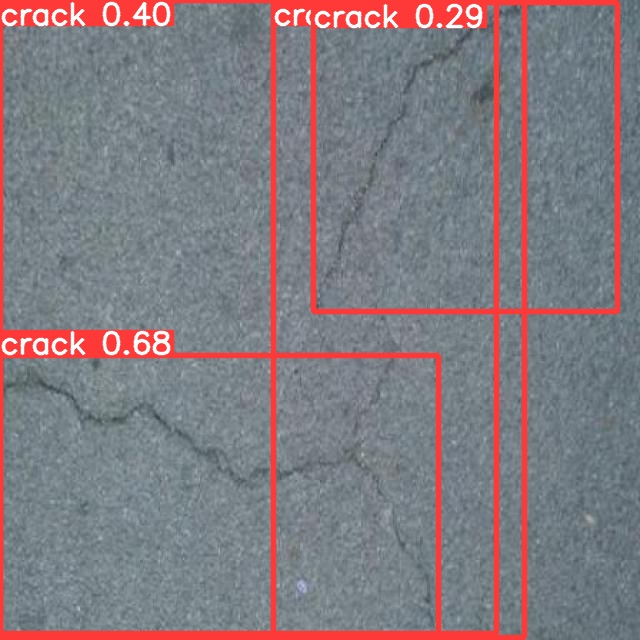

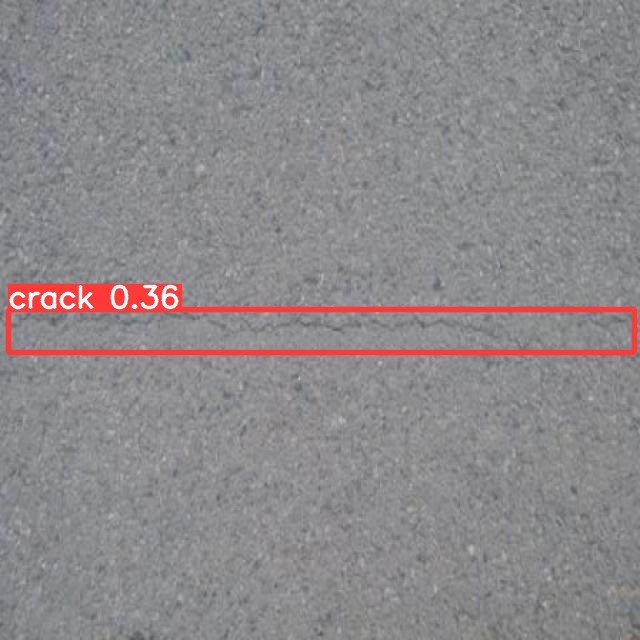

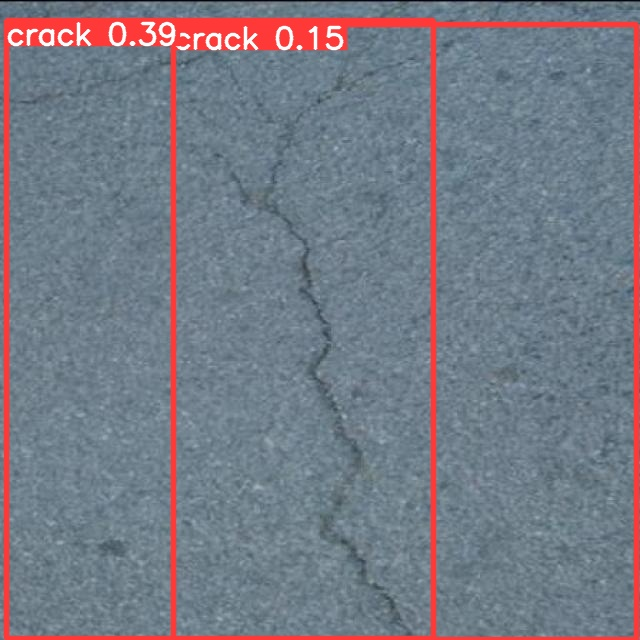

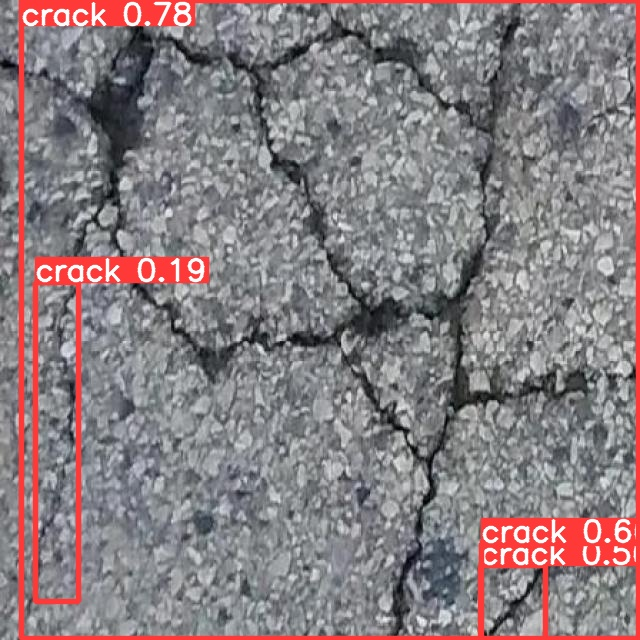

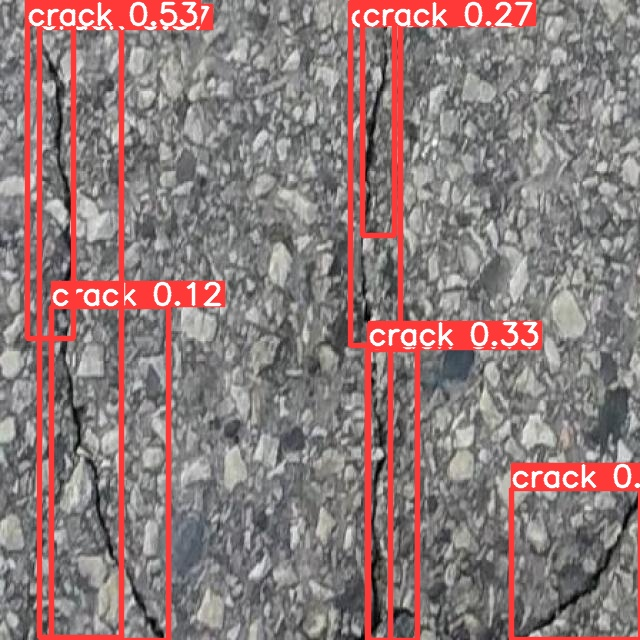

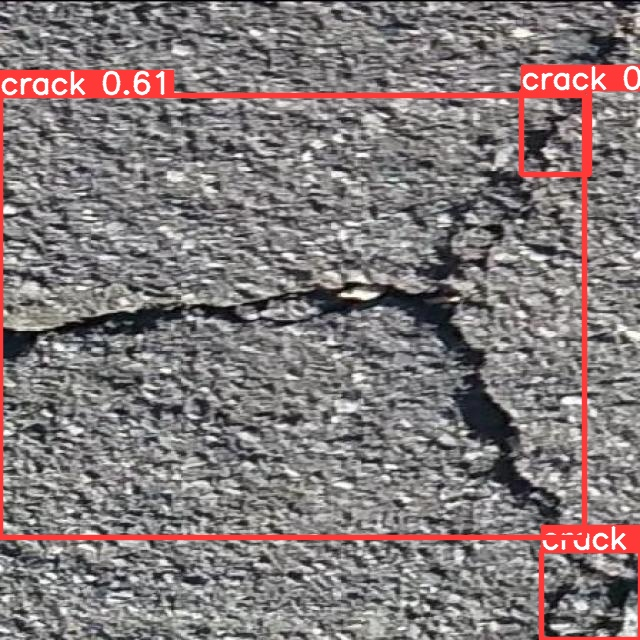

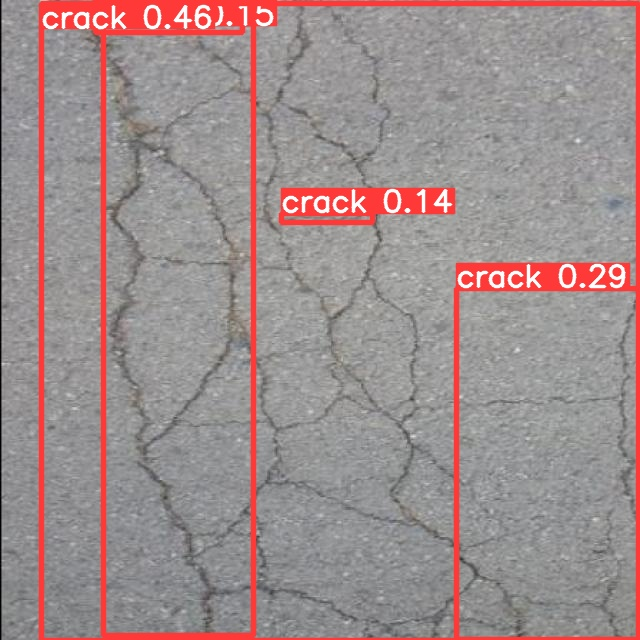

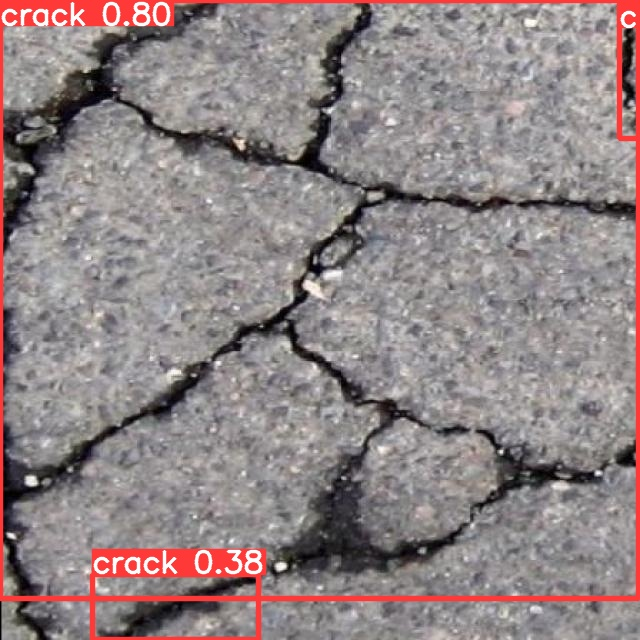

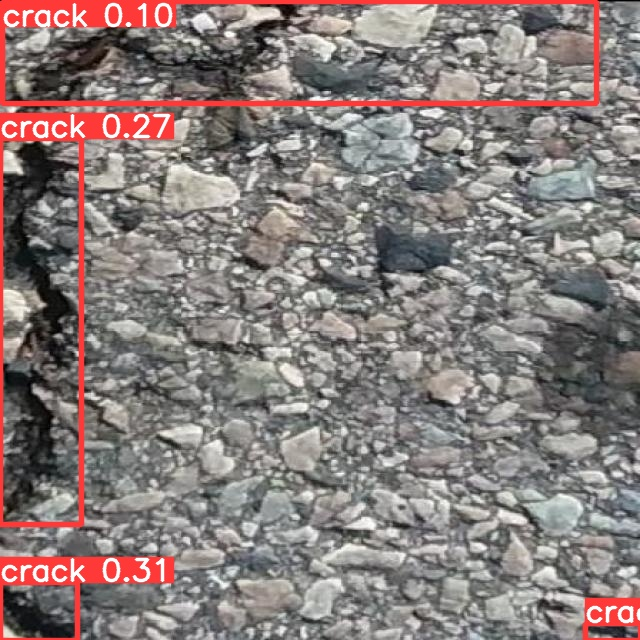

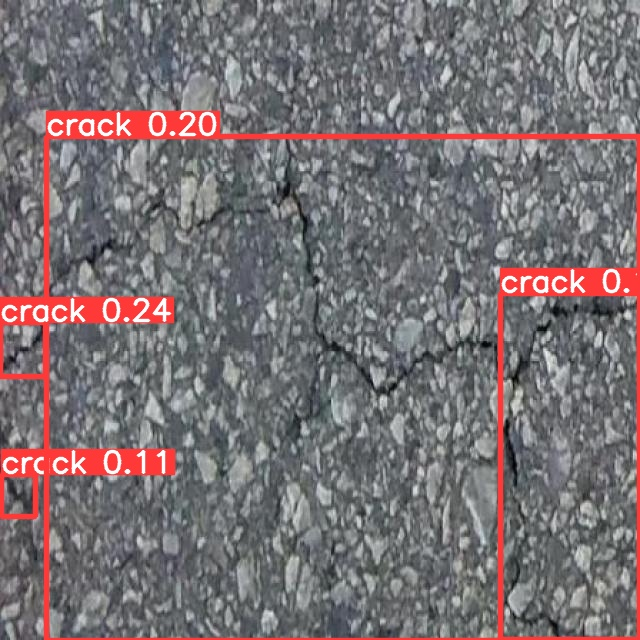

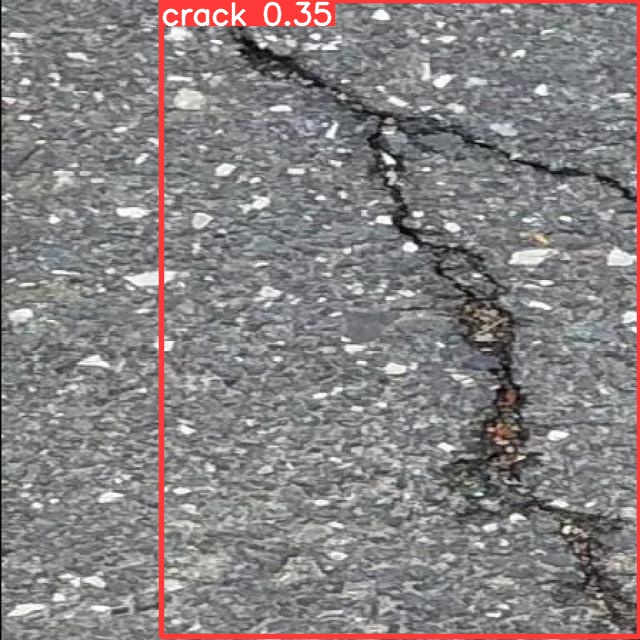

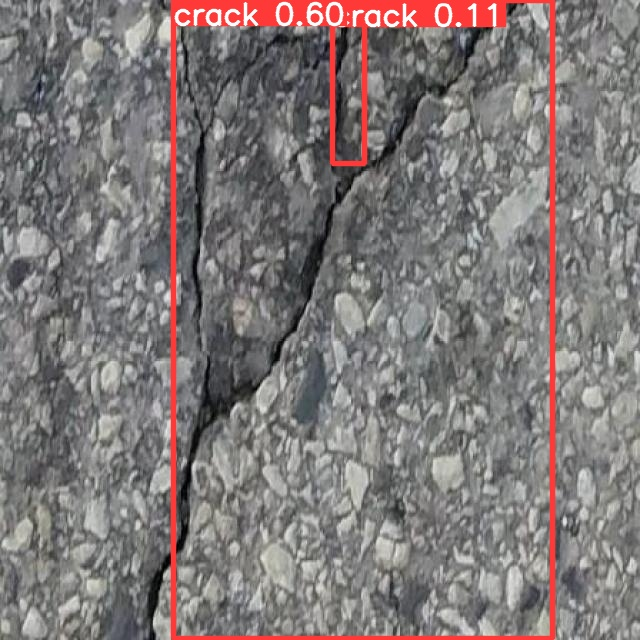

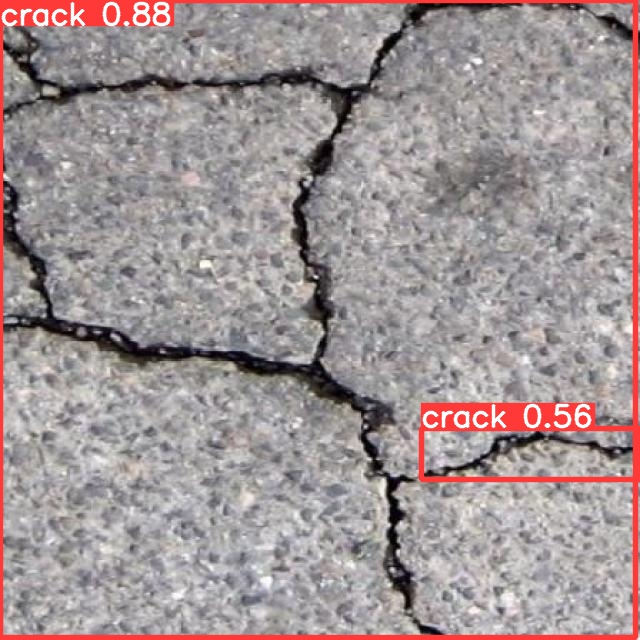

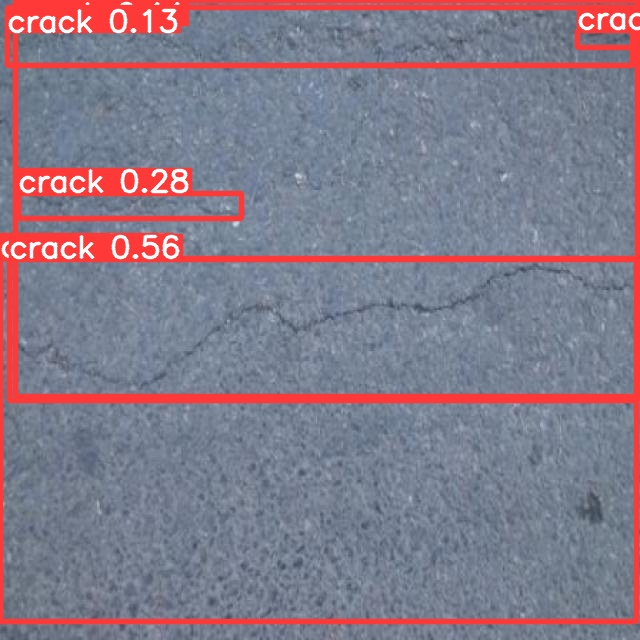

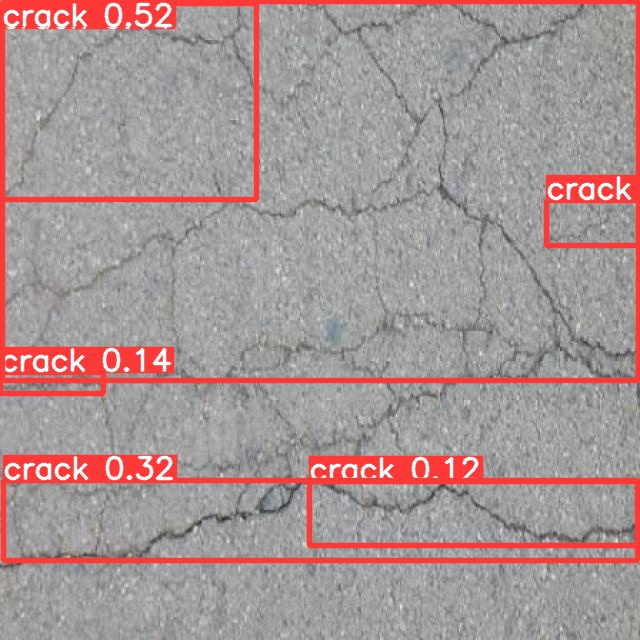

In [35]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:30]:
      display(Image(filename=image_path, width=600))
      print("\n")